In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm, expon, gamma, skewnorm
import os.path
from sklearn.cluster import AgglomerativeClustering, SpectralBiclustering, SpectralCoclustering, KMeans
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import IPython

import sys
sys.setrecursionlimit(10000)

from configMaker import get_model_name

dataset_type = 'mnist_small'
model_type = 'logreg_lbfgs'#'all_cnn_c_hidden'
out = '../output-week6'
nametag = 'cluster'
seeds = [0]
num_train_points = 5500
num_test_points = 10000
num_seeds = len(seeds)
num_classes = 10

test_idx=6558

fontsize=16
sns.set(color_codes=True)
sns.set_style('white')

def ceil_divide(numer,denom):
    return (numer-1)//denom+1

f = np.load('../../output/mnist_small_save.npz')
train_images = np.reshape(np.array(f['train_images']),(-1,28,28))
train_images_flat = np.reshape(train_images,(-1,28**2))
train_labels = np.array(f['train_labels'])
validation_images = np.reshape(np.array(f['validation_images']),(-1,28,28))
validation_labels = np.array(f['validation_labels'])
validation_images_flat = np.reshape(validation_images,(-1,28**2))
test_images = np.reshape(np.array(f['test_images']),(-1,28,28))
test_labels = np.array(f['test_labels'])
test_images_flat = np.reshape(test_images,(-1,28**2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_influence_vectors(seed, ignore_hess, test_idx):
    model_name = get_model_name(nametag=nametag, dataset_type=dataset_type, model_type=model_type, seed=seed)
    f = np.load('../{}/{}_influence_vectors-{}-ignoring-hess-{}.npz'.format(out,model_name,test_idx,ignore_hess))
    return f['infl_vectors']

def visualize(ax, idx, group='train'):
    assert group in ['train', 'test']
    ax.set_aspect('equal')
    if group == 'train':
        ax.imshow(train_images[idx])
        ax.set_title('Train image {} ({})'.format(idx, train_labels[idx]), fontsize=fontsize)
    elif group == 'test':
        ax.imshow(test_images[idx])
        ax.set_title('Test image {} ({})'.format(idx, test_labels[idx]), fontsize=fontsize)

def make_subplots(height, width, sharex=False, sharey=False):
    fig, axs = plt.subplots(height, width, sharex=sharex, sharey=sharey, figsize=(5*width, 5*height))
    return fig, axs

def colormesh(ax, data, norm):
    ax.pcolormesh(data,cmap=plt.cm.bwr,norm=norm)

def plot_scatter(ax, data, offset, alpha=0.3):
    ax.scatter(range(len(data)), np.array(data)+offset, alpha=alpha, s=1)
    
def plot_and_cluster_matrix(data, n_clusters=5, color_scaling=1, n_visualize=3, visualizing=True, label_pies=True):
    norm = colors.Normalize(data.min()/color_scaling,data.max()/color_scaling)
    fig, axs = make_subplots(1, 2)
    colormesh(axs[0], data, norm)
    
    km = KMeans(n_clusters=n_clusters)
    km = km.fit(data)
    labels = km.labels_
    centroids = km.cluster_centers_
    #colormesh(axs[1], centroids, norm)
    for i, cent in enumerate(centroids):
        plot_scatter(axs[1], cent, i)
    axs[1].set_ylim(-1,n_clusters)
    plt.show()

    if visualizing:
        fig, axs = make_subplots(n_clusters*2, n_visualize)
        for cluster_num in range(n_clusters):
            row = axs[2*cluster_num]
            poss_indices = np.where(labels == [cluster_num] * len(labels))[0]
            row[0].set_ylabel('Cluster {} ({})'.format(cluster_num, len(poss_indices)))
            rand_indices = np.zeros(n_visualize,dtype=np.int)
            for i, ax in enumerate(row):
                rand_indices[i] = np.random.choice(poss_indices)
                visualize(ax, rand_indices[i], 'train')
            row = axs[2*cluster_num+1]
            for i, ax in enumerate(row):
                plot_scatter(ax, centroids[cluster_num], 0)
                plot_scatter(ax, data[rand_indices[i]], 1)
                ax.set_ylim(-1, 2)
                #colormesh(ax, [centroids[cluster_num], data[rand_indices[i]]], norm)
        plt.show()
    
    if label_pies:
        fig, axs = make_subplots(4, ceil_divide(n_clusters+1, 4))
        for i, row in enumerate(axs):
            for j, ax in enumerate(row):
                cluster_num = len(row) * i + j
                if cluster_num < n_clusters:
                    c = Counter(train_labels[km.labels_ == cluster_num])
                    ax.pie([c[k] for k in range(num_classes)], labels = range(num_classes))
                    ax.set_title('Cluster {} ({})'.format(cluster_num, list(km.labels_).count(cluster_num)))
                elif cluster_num == n_clusters:
                    c = Counter(train_labels)
                    ax.pie([c[k] for k in range(num_classes)], labels = range(num_classes))
                    ax.set_title('All ({})'.format(len(train_labels)))
        plt.show()
    
    return km
            
infl_vectors_no_hess = get_influence_vectors(seeds[0], True, test_idx)

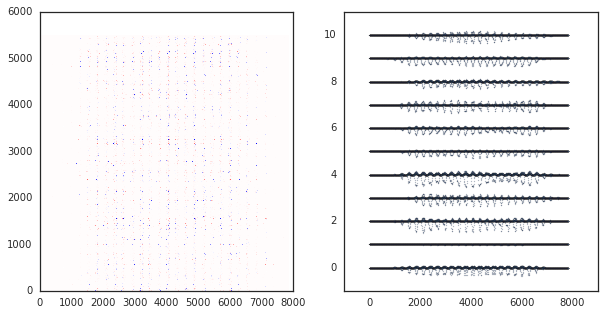

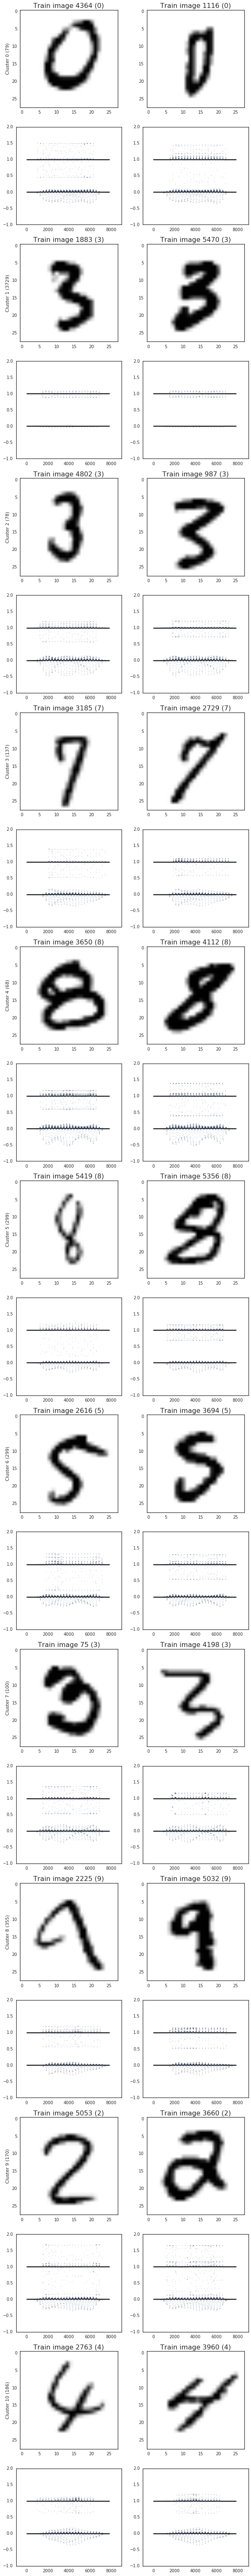

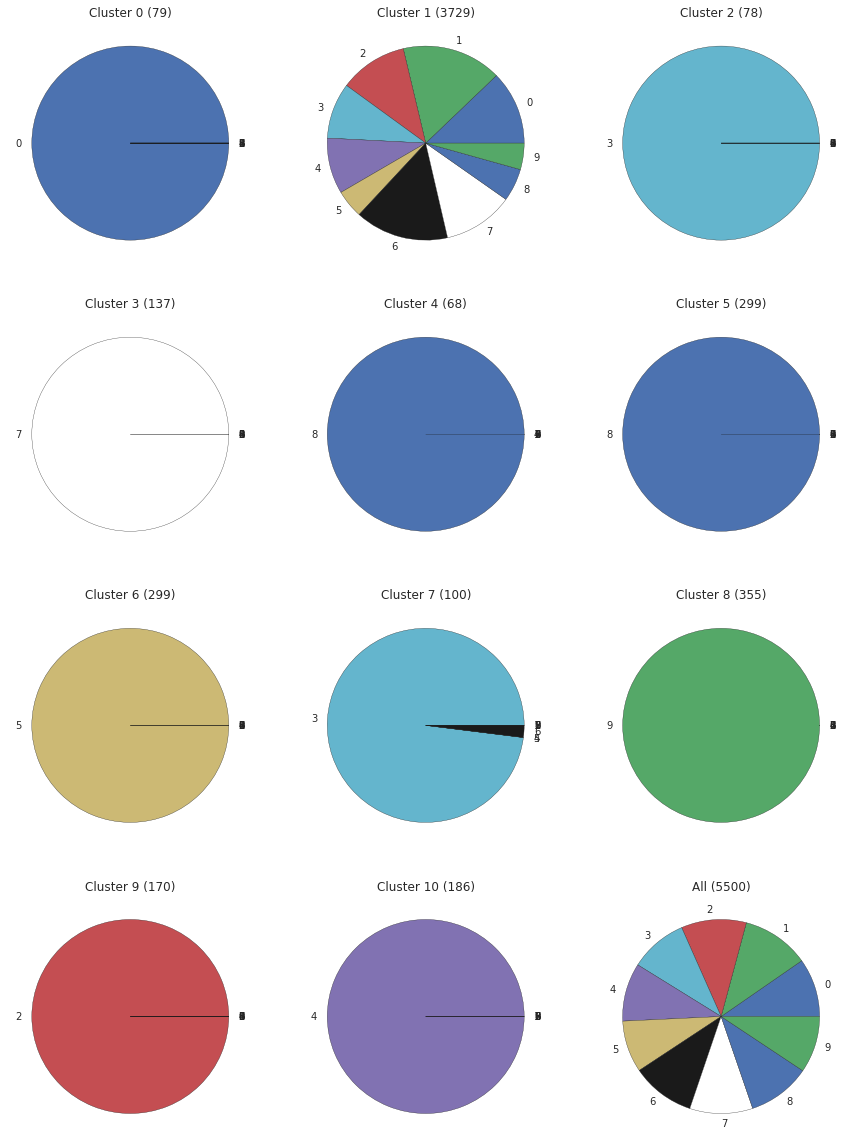

In [3]:
km = plot_and_cluster_matrix(infl_vectors_no_hess, n_clusters=11, n_visualize=2)

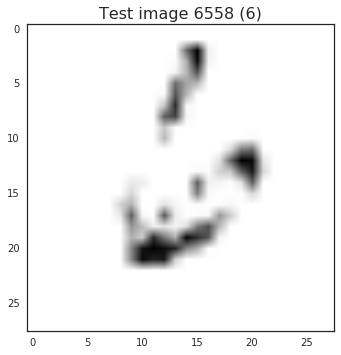

In [4]:
visualize(plt.axes(), test_idx, 'test')

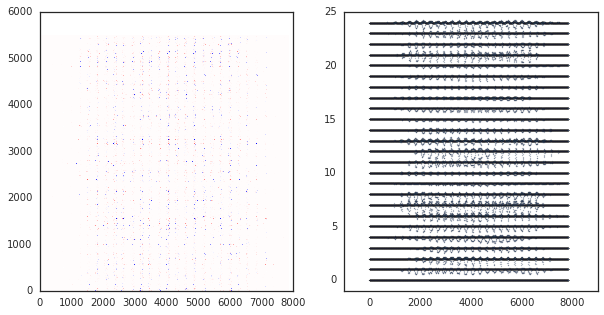

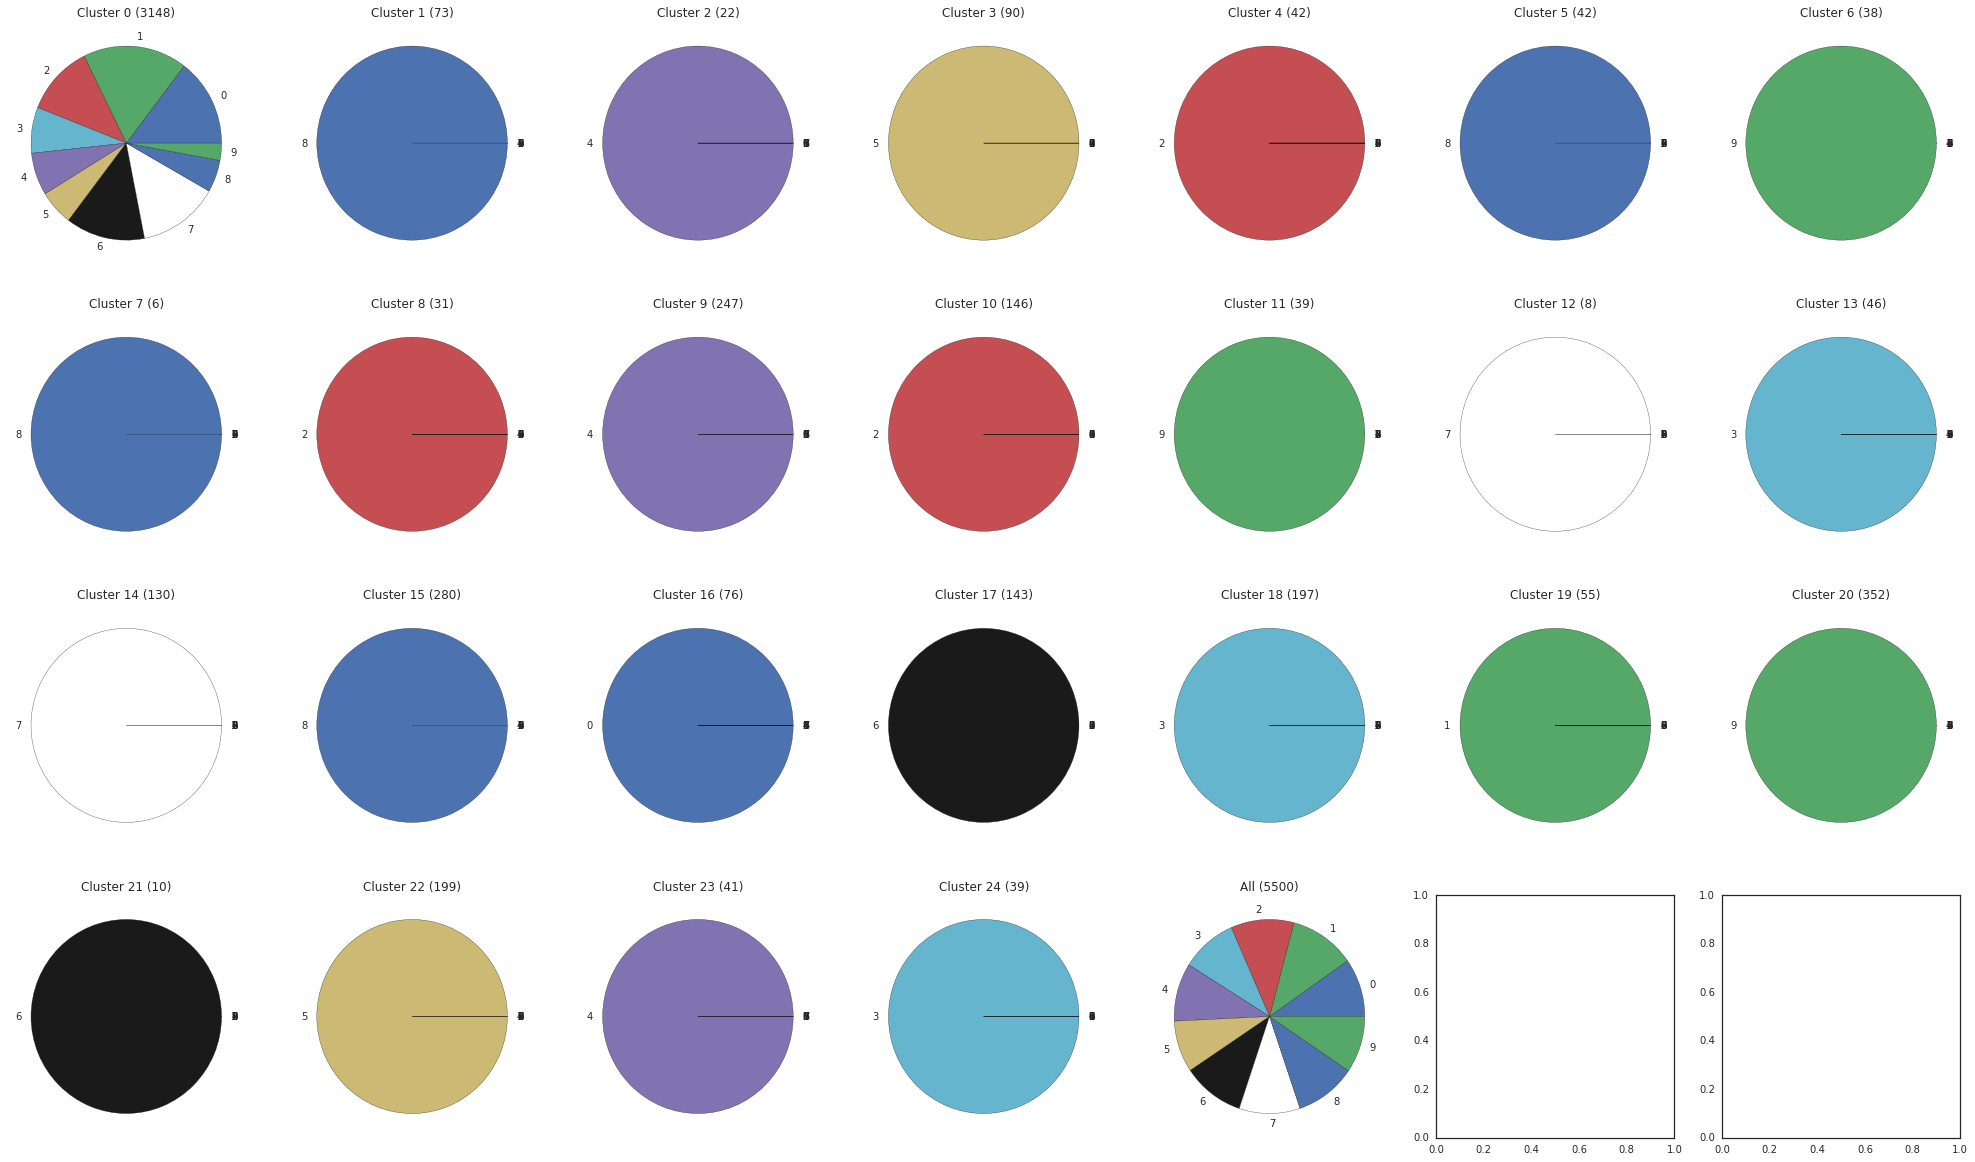

UnboundLocalError: local variable 'rand_indices' referenced before assignment

In [5]:
plot_and_cluster_matrix(infl_vectors_no_hess, n_clusters=25, n_visualize=1, visualizing=False)

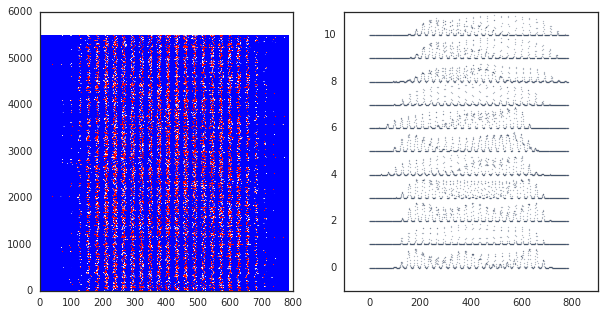

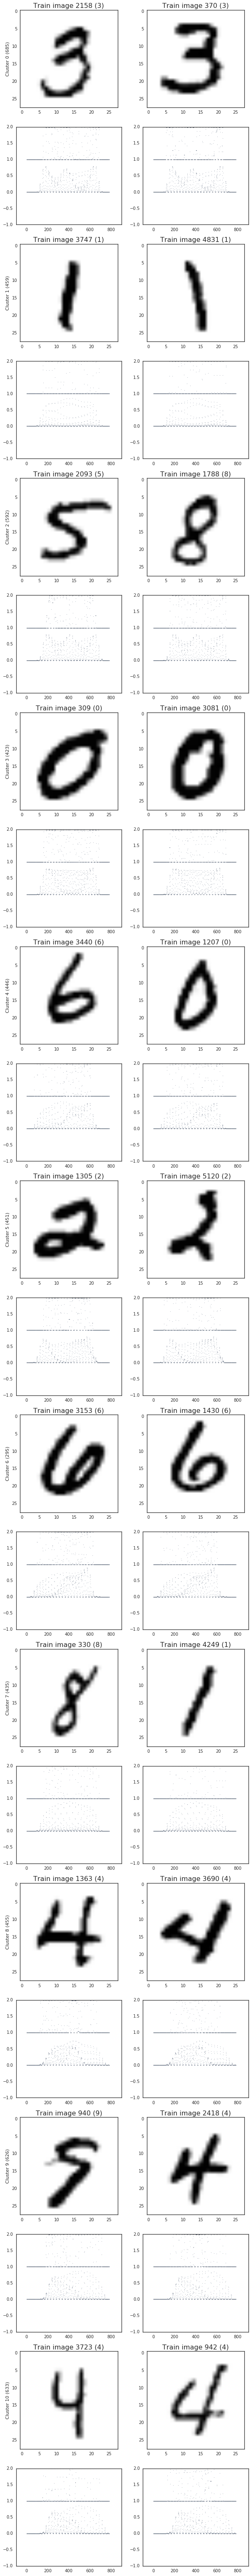

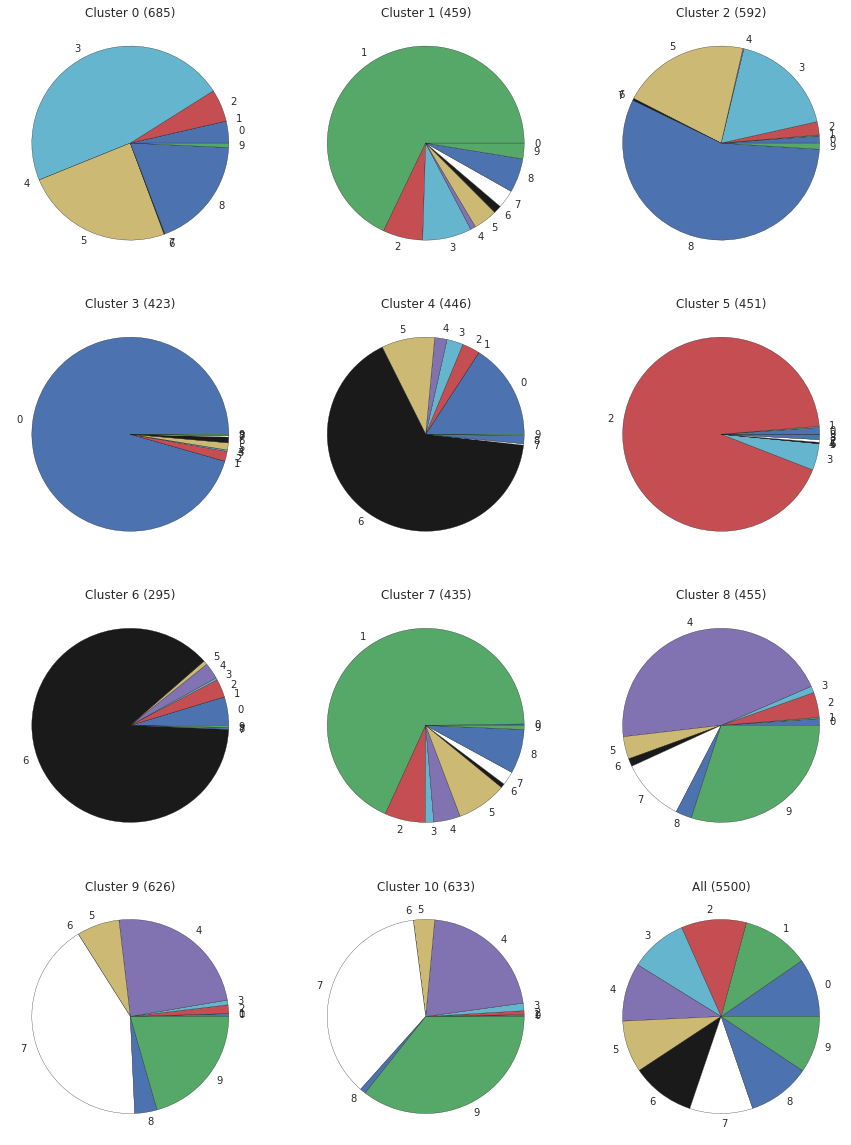

(KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 array([3723,  942]),
 <matplotlib.colors.Normalize at 0x7f4368529a50>)

In [10]:
plot_and_cluster_matrix(train_images_flat, n_clusters=11, n_visualize=2)